# Marinminds battery remaining useful life (RUL) predictor

### Step -1: Import all the packages we need

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
from sys import platform

### Step 0: Define the variables

In [2]:
scaler = StandardScaler()
model_path = 'models/saved/'
model_name = 'dilated_cnn_rul_prediction_custom_v1.4'
full_path = model_path + model_name + '.h5'
window_size = 72  # In hours

### Step 1: Load an exisitng model, or create a new one

In [3]:
# Either load the model
if os.path.exists(full_path):
    untrained_model = False
# Or create a new model
else:
    model = tf.keras.models.Sequential()

    # The convolutional filter layers
    model.add(tf.keras.layers.Conv2D(filters=24, kernel_size=3, activation='relu', input_shape=(window_size, 3, 1), padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=24, kernel_size=3, activation='relu', dilation_rate=1, padding='same'))
    model.add(tf.keras.layers.Conv2D(filters=24, kernel_size=3, activation='relu', dilation_rate=3, padding='same'))
    # model.add(tf.keras.layers.Conv2D(filters=24, kernel_size=3, activation='relu', dilation_rate=9, padding='same'))
    # model.add(tf.keras.layers.Conv2D(filters=24, kernel_size=3, activation='relu', dilation_rate=27, padding='same'))
    
    # 1 dimentional channel compressor
    model.add(tf.keras.layers.Flatten())

    # Fully connected layers
    model.add(tf.keras.layers.Dense(units=1000, activation='relu'))
    model.add(tf.keras.layers.Dense(units=100))
    model.add(tf.keras.layers.Dense(units=1))

    model.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
    untrained_model = True

model.summary()
print('New model created' if untrained_model else 'Existing model loaded')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 72, 3, 24)         240       
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 3, 24)         5208      
                                                                 
 flatten (Flatten)           (None, 5184)              0         
                                                                 
 dense (Dense)               (None, 1000)              5185000   
                                                                 
 dense_1 (Dense)             (None, 100)               100100    
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,290,649
Trainable params: 5,290,649
Non-

### Step 2: Load the dataset used for training or inferencing

#### Step 2.1: Below the functions for processing the dataset

In [4]:
def process_data(data, feature_col, target_col, split_ratio=0.8):
    (X, y) = window_data(data, window_size, feature_col, target_col)
    
    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y)

    split_index = int((data.shape[0] - window_size - 1) * split_ratio)

    X_train = X[:split_index]
    X_test = X[split_index:]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    y_train = y[:split_index]
    y_test = y[split_index:]
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

    return X_train, y_train, X_test, y_test


def window_data(df, window, feature_col_number, target_col_number):
    X, y = [], []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number].values
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).astype(np.float64).reshape(-1, 1)

#### Step 2.2: Now load the dataset

In [16]:
def get_data(path, features, split_ratio=0.8, split_data=True):
    if platform == 'linux':
        path = path.replace('C:/Users/', '/mnt/c/Users/')
    dataset = pd.read_csv(path)
    data = dataset[features]

    if not split_data:
        split_ratio = 0

    (_, y) = window_data(data, window_size, 0, 0)
    split = int((data.shape[0] - window_size - 1) * split_ratio)
    y_train = y[:split]
    y_test = y[split:]

    X_train_a, _, X_test_a, _ = process_data(data, 1, 0, split_ratio=split_ratio)
    X_train_b, _, X_test_b, _ = process_data(data, 2, 0, split_ratio=split_ratio)
    X_train_c, _, X_test_c, _ = process_data(data, 3, 0, split_ratio=split_ratio)

    X_train_data = np.concatenate((X_train_a, X_train_b, X_train_c), axis=2)
    X_test_data = np.concatenate((X_test_a, X_test_b, X_test_c), axis=2)

    # Reshape the 3 dimensional array into a 4 dimensional array
    X_train_data = X_train_data.reshape((X_train_data.shape[0], X_train_data.shape[1], X_train_data.shape[2], 1))
    X_test_data = X_test_data.reshape((X_test_data.shape[0], X_test_data.shape[1], X_test_data.shape[2], 1))

    return X_train_data, y_train, X_test_data, y_test


data_base_path = 'C:/Users/evert/School/hanzehogeschool-software-engineering/Jaar4/Afstuderen/Data/Battery-CVT-data/'

ship_alpha_path = os.path.join(data_base_path, 'alpha/alpha-electrical-battery-all-sensors.csv')
ship_beta_path = os.path.join(data_base_path, 'beta/beta-electrical-battery-all-sensors.csv')
ship_gamma_path = os.path.join(data_base_path, 'gamma/gamma-electrical-battery-all-sensors.csv')

path_to_dataset = ship_alpha_path
features = ['capacity','electrical.batteries.0.current.last','electrical.batteries.0.voltage.last','electrical.batteries.0.temperature.last']

# path_to_dataset = 'C:/Users/evert/School/hanzehogeschool-software-engineering/Jaar4/Afstuderen/Repositories/mm-development-environment/data/nasa-dataset/B0005.csv'
# features = ['capacity', 'voltage_measured', 'current_measured', 'temperature_measured']

train_test_split_ratio = 0.0
train_X, train_y, test_X, test_y = get_data(path_to_dataset, features, train_test_split_ratio, split_data=untrained_model)

print(train_X.shape, test_X.shape)

(0, 72, 3, 1) (2120, 72, 3, 1)


### Step 3: Train the model on the dataset

In [6]:
history = model.fit(train_X, train_y, epochs=10)
model.save(full_path)

Epoch 1/10
1256/1256 [==============================] - 23s 18ms/step - loss: 0.0192 - accuracy: 0.0000e+00
Epoch 2/10
1256/1256 [==============================] - 23s 18ms/step - loss: 0.0114 - accuracy: 0.0000e+00
Epoch 3/10
1256/1256 [==============================] - 22s 17ms/step - loss: 0.0103 - accuracy: 0.0000e+00
Epoch 4/10
1256/1256 [==============================] - 21s 17ms/step - loss: 0.0096 - accuracy: 0.0000e+00
Epoch 5/10
1256/1256 [==============================] - 22s 18ms/step - loss: 0.0089 - accuracy: 0.0000e+00
Epoch 6/10
1256/1256 [==============================] - 22s 17ms/step - loss: 0.0084 - accuracy: 0.0000e+00
Epoch 7/10
1256/1256 [==============================] - 22s 18ms/step - loss: 0.0077 - accuracy: 0.0000e+00
Epoch 8/10
1256/1256 [==============================] - 22s 17ms/step - loss: 0.0073 - accuracy: 0.0000e+00
Epoch 9/10
1256/1256 [==============================] - 22s 18ms/step - loss: 0.0066 - accuracy: 0.0000e+00
Epoch 10/10
1256/1256 [=====

#### *Optional: Show the training loss*

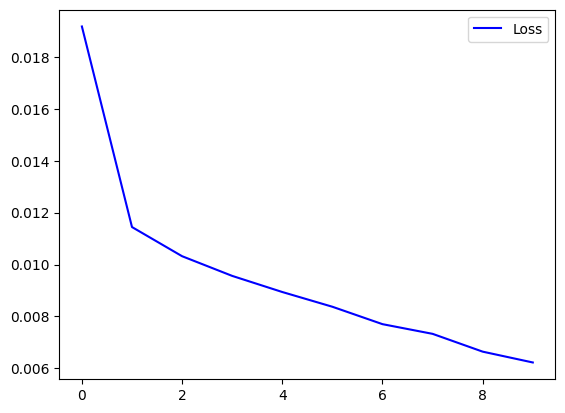

In [7]:
plt.figure()
plt.plot(history.history["loss"], color='blue', label='Loss')
plt.legend()
plt.show()

### Step 4: Make a prediction

In [17]:
predicted_data = model.predict(test_X)
real_data = test_y

print(predicted_data.shape)
print(real_data.shape)

67/67 [==============================] - 0s 5ms/step
(2120, 1)
(2120, 1)


### Step 5: Graph the prediction result

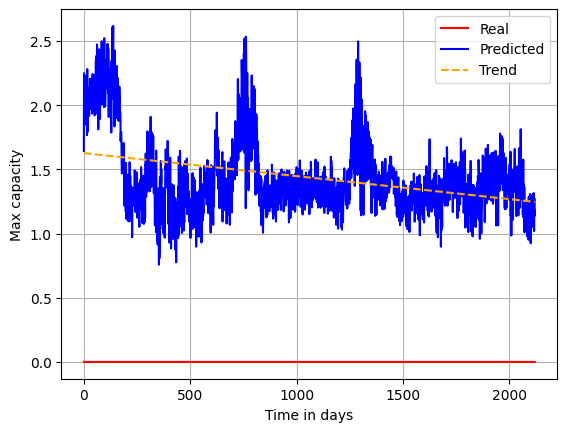

In [19]:
X = np.arange(predicted_data.shape[0])
y = predicted_data.flatten()

poly_fit = np.polyfit(X, y, 1)
trendline = np.poly1d(poly_fit)

plt.figure()
plt.plot(X, real_data, color='red', label='Real')
plt.plot(X, y, color='blue', label='Predicted')
plt.plot(X, trendline(X), color='orange', linestyle='--', label='Trend')
plt.xlabel('Time in days')
plt.ylabel('Max capacity')

plt.grid()
plt.legend()
plt.show()